In [1]:
import glob
import os
import json
import pickle
import yaml

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import utils_farouk as utils
plt.rcParams.update({"font.size": 20})

/opt/anaconda3/envs/coffea-env/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
! ls ../

Analysis Roadmap.png   boostedhiggs           requirements.txt
Apr12_presel_2016      bootstrap.sh           rootfiles
Apr12_presel_2016APV   check_jobs.py          run.py
Apr12_presel_2017      condor                 samples_inclusive.yaml
Apr12_presel_2018      fileset                samples_vh.yaml
Feb22_2017             lumi                   setup.md
Mar23_2017             new                    setup.py
Mar26_2017             pfnano_splitting.yaml  setup.sh
POG                    print_parquet.py       trigger_output
README.md              prp                    zll
binder                 python                 zll_2017


In [4]:
! ls ../Apr12_presel_2017

DYJetsToLL_Pt-100To250                  SingleElectron_Run2017F
DYJetsToLL_Pt-250To400                  SingleMuon_Run2017B
DYJetsToLL_Pt-400To650                  SingleMuon_Run2017C
DYJetsToLL_Pt-50To100                   SingleMuon_Run2017D
DYJetsToLL_Pt-650ToInf                  SingleMuon_Run2017E
GluGluHToTauTau                         SingleMuon_Run2017F
GluGluHToWW_Pt-200ToInf_M-125           TTTo2L2Nu
GluGluZH_HToWW_ZTo2L_M-125              TTToHadronic
HWminusJ_HToWW_M-125                    TTToSemiLeptonic
HWplusJ_HToWW_M-125                     VBFHToWWToLNuQQ_M-125_withDipoleRecoil
HZJ_HToWW_M-125                         WJetsToLNu_HT-100To200
QCD_Pt_1000to1400                       WJetsToLNu_HT-1200To2500
QCD_Pt_1400to1800                       WJetsToLNu_HT-200To400
QCD_Pt_170to300                         WJetsToLNu_HT-2500ToInf
QCD_Pt_1800to2400                       WJetsToLNu_HT-400To600
QCD_Pt_2400to3200                       WJetsToLNu_HT-600To800
QCD_Pt_300to470 

In [5]:
# # counts number of events for a given sample after skimming
# samples_dir = "../Mar23_2017/"
# for sample in os.listdir(samples_dir):
# #     if sample != "SingleMuon_Run2017E":
# #         continue
#     out_files = f"{samples_dir}/{sample}/outfiles/"
#     parquet_files = glob.glob(f"{out_files}/*_{ch}.parquet")
    
#     if not parquet_files:
#         print(f"No parquet file for {sample}")
#         continue                

#     data = pd.read_parquet(parquet_files)
#     not_empty = len(data) > 0

#     print(f"Finding {len(data)} events for {sample}")

# Read parquets
- loads parquet dataframes and combine different pT-bins per sample
- applies the preselection specefied in the next cell
- saves the combined dataframe under `events[ch][sample]`

In [65]:
presel = {
    "mu": {
#         ### already applied in processor
#         "isolation": "( ( (lep_pt < 55) & (lep_isolation<0.15)) |  (lep_pt >= 55) )",
#         "invert isolation": "( ( (lep_pt < 55) & (lep_isolation>0.15)) |  (lep_pt >= 55) )",

#         "mini-isolation": "( (lep_pt < 55) |  ( (lep_misolation < 0.2) & (lep_pt >= 55) ) )",
#         "invert mini-isolation": "( (lep_pt < 55) |  ( (lep_misolation > 0.2) & (lep_pt >= 55) ) )",

        ### checks
#         "lep_fj_dr": "( ( lep_fj_dr>0.03) )",   
#         "nbjets": "( (n_bjets_M < 2) )",
    },
    "ele": {
#         ### already applied in processor
#         "isolation": "( ( (lep_pt < 120) & (lep_isolation<0.15)) |  (lep_pt >= 120) )",    
#         "invert isolation": "( ( (lep_pt < 120) & (lep_isolation>0.15)) |  (lep_pt >= 120) )",

        ### checks
#         "lep_fj_dr": "( ( lep_fj_dr>0.03) )",
#         "nbjets": "( (n_bjets_M < 2) )",
    }    
}

In [66]:
year = "2017"
channels = ["mu", "ele"]
# channels = ["ele"]
samples_dir = "../Mar26_2017"
samples_dir = f"../Apr12_presel_{year}"

samples = [
    "HWW", 
    "VH",
    "VBF",
    "ttH",
    "QCD",
    "DYJets",
    "WJetsLNu",
    "WZQQ",
    "TTbar",
    "SingleTop",
    "Diboson",
    "Data"
]

In [67]:
events_dict = utils.event_skimmer(year, channels, samples_dir, samples, presel, "all", add_qcd_score=True, add_top_score=True, add_inclusive_score=True)

Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L1Prefiring weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
Applying weight_isolation_muon weight
Applying weight_id_muon weight
Applying weight_vjets_nominal weight
---> Done with accumulating event weights.
Will fill the WJetsLNu dataframe with the remaining 37101 events
tot event weight 58944.13282458637 

Finding DYJetsToLL_Pt-400To650 samples and should combine them under DYJets
---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L1Prefiring weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
Applying weight_isolation_muon weight
Applying weight

Finding ZJetsToQQ_HT-200to400 samples and should combine them under WZQQ
---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L1Prefiring weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
Applying weight_isolation_muon weight
Applying weight_id_muon weight
Applying weight_vjets_nominal weight
---> Done with accumulating event weights.
Will fill the WZQQ dataframe with the remaining 7 events
tot event weight 30.59786623124888 

Finding SingleElectron_Run2017E samples and should combine them under Data
Finding SingleElectron_Run2017B samples and should combine them under Data
Finding QCD_Pt_3200toInf samples and should combine them under QCD
---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L1Prefiring weight
Applying weight_pileup weight
Applying

Will fill the DYJets dataframe with the remaining 101802 events
tot event weight 83.89696018235412 

ATTENTION: GluGluHToTauTau will be skipped
Finding ZJetsToQQ_HT-400to600 samples and should combine them under WZQQ
---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L1Prefiring weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
Applying weight_isolation_muon weight
Applying weight_id_muon weight
Applying weight_vjets_nominal weight
---> Done with accumulating event weights.
Will fill the WZQQ dataframe with the remaining 537 events
tot event weight 254.6532312646323 

Finding ZZ samples and should combine them under Diboson
---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L1Prefiring weight
Applying weight_pileup weight
Applying weight_trigge

---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L1Prefiring weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
Applying weight_isolation_muon weight
Applying weight_id_muon weight
Applying weight_vjets_nominal weight
---> Done with accumulating event weights.
Will fill the WZQQ dataframe with the remaining 117 events
tot event weight 269.02050645751507 

Finding WJetsToLNu_HT-400To600 samples and should combine them under WJetsLNu
---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L1Prefiring weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
Applying weight_isolation_muon weight
Applying weight_id_muon weight
Applying weight_vjets_nominal weight
---> Done with accumulating 

Finding ST_t-channel_top_4f_InclusiveDecays samples and should combine them under SingleTop
---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L1Prefiring weight
Applying weight_pileup weight
Applying weight_trigger_electron weight
Applying weight_reco_electron weight
Applying weight_id_electron weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the SingleTop dataframe with the remaining 73480 events
tot event weight 1994.3630196386541 

Finding ST_s-channel_4f_hadronicDecays samples and should combine them under SingleTop
Finding WJetsToLNu_HT-1200To2500 samples and should combine them under WJetsLNu
---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L1Prefiring weight
Applying weight_pileup weight
Applying weight_trigger_electron weight
Applying weig

Finding QCD_Pt_1800to2400 samples and should combine them under QCD
---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L1Prefiring weight
Applying weight_pileup weight
Applying weight_trigger_electron weight
Applying weight_reco_electron weight
Applying weight_id_electron weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the QCD dataframe with the remaining 1727 events
tot event weight 1.1217295894746688 

Finding SingleMuon_Run2017E samples and should combine them under Data
Finding SingleMuon_Run2017B samples and should combine them under Data
Finding WW samples and should combine them under Diboson
---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L1Prefiring weight
Applying weight_pileup weight
Applying weight_trigger_electron weight
Applying wei

---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L1Prefiring weight
Applying weight_pileup weight
Applying weight_trigger_electron weight
Applying weight_reco_electron weight
Applying weight_id_electron weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the QCD dataframe with the remaining 2661 events
tot event weight 341558.3324173747 

Finding WJetsToLNu_HT-600To800 samples and should combine them under WJetsLNu
---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L1Prefiring weight
Applying weight_pileup weight
Applying weight_trigger_electron weight
Applying weight_reco_electron weight
Applying weight_id_electron weight
Applying weight_vjets_nominal weight
---> Done with accumulating event weights.
Will fill the WJetsLNu dataframe with the remainin

# Plot histograms

## 1d-hists

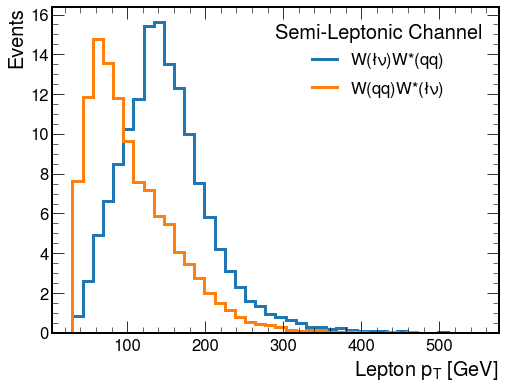

In [10]:
### Example of a 1-d histogram
# make simple 1d-histogram of `lep_pt`
plt.rcParams.update({"font.size": 20})

h = hist2.Hist(
    hist2.axis.Regular(40, 30, 550, name="var", label=r"Lepton $p_T$ [GeV]", overflow=True),
    hist2.axis.Boolean(name="from_W")        
)

for ch in ["mu", "ele"]:
    
    h.fill(
        var=events_dict[ch]["HWW"]["lep_pt"],
        from_W=events_dict[ch]["HWW"]["fj_H_VV_isVlepton"]==True,
        weight=events_dict[ch]["HWW"]["event_weight"]
    )

fig, ax = plt.subplots(figsize=(8, 6))

hep.histplot(
    h[{"from_W": 1}],
    ax=ax,
    label=r"W($\l\nu$)W*(qq)",
    linewidth=3,
#     density=True
)
hep.histplot(
    h[{"from_W": 0}],
    ax=ax,
    label=r"W(qq)W*($\l\nu$)",
    linewidth=3,
#     density=True    
)
     
ax.legend(title=f"Semi-Leptonic Channel")
ax.set_ylabel("Events");  

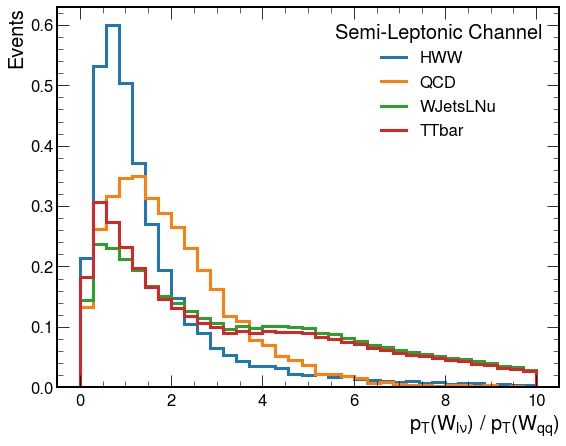

In [11]:
samples_to_plot = [
    "HWW", 
#     "VH",
#     "VBF",
#     "ttH",
    "QCD",
#     "DYJets",
    "WJetsLNu",
    "TTbar",
]

### Example of a 1-d histogram
# make simple 1d-histogram of `lep_pt`
plt.rcParams.update({"font.size": 20})

var = "golden_var"

h = hist2.Hist(
    utils.axis_dict[var],
)

fig, ax = plt.subplots(figsize=(9, 7))

for sample in samples_to_plot:
    for ch in channels:

        df = events_dict[ch][sample]
        
        # tagger cut
#         df = df[df["inclusive_score"]>0.9]
#         df = df[df["fj_bjets"]<0.3]
#         df = df[(df["rec_W_lnu_pt"]/df["rec_W_qq_pt"])<4.8]
        if var=="golden_var":
            h.fill(
                var=df["rec_W_lnu_pt"]/df["rec_W_qq_pt"],
                weight=df["event_weight"]
            ) 
        else:
            h.fill(
                var=df[var],
                weight=df["event_weight"]
            )

    hep.histplot(
        h,
        ax=ax,
        label=sample,
        linewidth=3,
        density=True
    )

ax.legend(title=f"Semi-Leptonic Channel")
ax.set_ylabel("Events");  

## Stacked hists

In [16]:
# plot histograms
color_by_sample = {
    "HWW": "pink",
    "VH": "tab:brown",
    "VBF": "tab:gray",
    "ttH": "tab:olive",
    
    "DYJets": "tab:purple",
    "QCD": "tab:orange",
    "Diboson": "orchid",    
    "WJetsLNu": "tab:green",
    "TTbar": "tab:blue",
    "WZQQ": "salmon",
    "SingleTop": "tab:cyan",
    
#     "WplusHToTauTau": "tab:cyan",
#     "WminusHToTauTau": "tab:cyan",
#     "ttHToTauTau": "tab:cyan",
#     "GluGluHToTauTau": "tab:cyan",
#     "ZHToTauTau": "tab:cyan",
#     "VBFHToTauTau": "tab:cyan",
}

plot_labels = {
    "HWW": "ggH(WW)-Pt200",    
    "VH": "VH(WW)",
    "VBF": r"VBFH(WW) $(qq\ell\nu)$",
    "ttH": "ttH(WW)",
    
    "DYJets": r"Z$(\ell\ell)$+jets",    
    "QCD": "Multijet",
    "Diboson": "VV",
    "WJetsLNu": r"W$(\ell\nu)$+jets",
    "TTbar": r"$t\bar{t}$+jets",
    "WZQQ": r"W/Z$(qq)$",
    "SingleTop": r"Single Top",
    
#     "WplusHToTauTau": "WplusHToTauTau",
#     "WminusHToTauTau": "WminusHToTauTau",
#     "ttHToTauTau": "ttHToTauTau",
#     "GluGluHToTauTau": "GluGluHToTauTau",
#     "ZHToTauTau": "ZHToTauTau",
#     "VBFHToTauTau": "VBFHToTauTau"
}

label_by_ch = {
    "mu": "Muon",
    "ele": "Electron"
}

In [17]:
def plot_hists(year, channels, hists, vars_to_plot, add_data = True, logy = True, add_soverb = True, only_sig = False, mult=100):

    # luminosity
    luminosity = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum = json.load(f)[ch][year]
            luminosity += lum / 1000.0

    luminosity = luminosity/len(channels)
        
    for var in vars_to_plot:
        if var not in hists.keys():
            print(f"{var} not stored in hists")
            continue

        print(f"Will plot {var} histogram")

        # get histograms
        h = hists[var]

        if (h.shape[0] == 0):  # skip empty histograms (such as lepton_pt for hadronic channel)
            print("Empty histogram ", var)
            continue

        # get samples existing in histogram
        samples = [h.axes[0].value(i) for i in range(len(h.axes[0].edges))]
        signal_labels = [label for label in samples if label in utils.signals]
        bkg_labels = [
            label
            for label in samples
            if (label and label not in signal_labels and (label not in ["Data"]))
        ]

        # get total yield of backgrounds per label
        # (sort by yield in fixed fj_pt histogram after pre-sel)        
        order_dic = {}
        for bkg_label in bkg_labels:
            if "fj_pt" in hists.keys():
                order_dic[plot_labels[bkg_label]] = hists["fj_pt"][{"samples": bkg_label}].sum()
            else:
                order_dic[plot_labels[bkg_label]] = hists[var][{"samples": bkg_label}].sum()
            
        # data
        if add_data:
            data = h[{"samples": "Data"}]

        # signal
        signal = [h[{"samples": label}] for label in signal_labels]
        # scale signal for non-log plots
        if logy:
            mult_factor = 1
        else:
            mult_factor = mult
        signal_mult = [s * mult_factor for s in signal]

        # background
        bkg = [h[{"samples": label}] for label in bkg_labels]

        if add_data and data and len(bkg) > 0:
            if add_soverb and len(signal) > 0:
                fig, (ax, rax, sax) = plt.subplots(
                    nrows=3,
                    ncols=1,
                    figsize=(8, 8),
                    gridspec_kw={"height_ratios": (4, 1, 1), "hspace": 0.07},
                    sharex=True,
                )
            else:
                fig, (ax, rax) = plt.subplots(
                    nrows=2,
                    ncols=1,
                    figsize=(8, 8),
                    gridspec_kw={"height_ratios": (4, 1), "hspace": 0.07},
                    sharex=True,
                )
                sax = None
        else:
            if add_soverb and len(signal) > 0:
                fig, (ax, sax) = plt.subplots(
                    nrows=2,
                    ncols=1,
                    figsize=(8, 8),
                    gridspec_kw={"height_ratios": (4, 1), "hspace": 0.07},
                    sharex=True,
                )
                rax = None
            else:
                fig, ax = plt.subplots(figsize=(8,8))                
                rax = None
                sax = None

        errps = {
            "hatch": "////",
            "facecolor": "none",
            "lw": 0,
            "color": "k",
            "edgecolor": (0, 0, 0, 0.5),
            "linewidth": 0,
            "alpha": 0.4,
        }

        # sum all of the background
        if len(bkg) > 0:
            tot = bkg[0].copy()
            for i, b in enumerate(bkg):
                if i > 0:
                    tot = tot + b

            tot_val = tot.values()
            tot_val_zero_mask = tot_val == 0
            tot_val[tot_val_zero_mask] = 1

            tot_err = np.sqrt(tot_val)
            tot_err[tot_val_zero_mask] = 0

        if add_data and data:
            data_err_opts = {
                "linestyle": "none",
                "marker": ".",
                "markersize": 10.0,
                "elinewidth": 1,
            }
            hep.histplot(
                data,
                ax=ax,
                histtype="errorbar",
                color="k",
                capsize=4,
                yerr=True,
                label="Data",
                **data_err_opts,
            )

            if len(bkg) > 0:
                from hist.intervals import ratio_uncertainty

                data_val = data.values()
                data_val[tot_val_zero_mask] = 1

                yerr = ratio_uncertainty(data_val, tot_val, "poisson")

                hep.histplot(
                    data_val / tot_val,
                    tot.axes[0].edges,
                    yerr=yerr,
                    ax=rax,
                    histtype="errorbar",
                    color="k",
                    capsize=4,
                )

                rax.axhline(1, ls="--", color="k")
                rax.set_ylim(0.2, 1.8)

        # plot the background
        if len(bkg) > 0 and not only_sig:
            hep.histplot(
                bkg,
                ax=ax,
                stack=True,
                sort="yield",
                edgecolor="black",
                linewidth=1,
                histtype="fill",
                label=[plot_labels[bkg_label] for bkg_label in bkg_labels],
                color=[color_by_sample[bkg_label] for bkg_label in bkg_labels],
            )
            ax.stairs(
                values=tot.values() + tot_err,
                baseline=tot.values() - tot_err,
                edges=tot.axes[0].edges,
                **errps,
                label="Stat. unc.",
            )

        # plot the signal (times 10)
        if len(signal) > 0:
            tot_signal = None
            for i, sig in enumerate(signal_mult):
                lab_sig_mult = f"{mult_factor} * {plot_labels[signal_labels[i]]}"
                if mult_factor == 1:
                    lab_sig_mult = f"{plot_labels[signal_labels[i]]}"
                hep.histplot(
                    sig,
                    ax=ax,
                    label=lab_sig_mult,
                    linewidth=3,
                    color=color_by_sample[signal_labels[i]],
                )

                if tot_signal == None:
                    tot_signal = signal[i].copy()
                else:
                    tot_signal = tot_signal + signal[i]

            # plot the total signal (w/o scaling)
            hep.histplot(
                tot_signal, ax=ax, label=f"ggF+VBF+VH+ttH", linewidth=3, color="tab:red"
            )
            # add MC stat errors
            ax.stairs(
                values=tot_signal.values() + np.sqrt(tot_signal.values()),
                baseline=tot_signal.values() - np.sqrt(tot_signal.values()),
                edges=sig.axes[0].edges,
                **errps,
            )

            if sax is not None:
                totsignal_val = tot_signal.values()
                # replace values where bkg is 0
                totsignal_val[tot_val == 0] = 0
                soverb_val = totsignal_val / np.sqrt(tot_val)
                hep.histplot(
                    soverb_val,
                    tot_signal.axes[0].edges,
                    label="Total Signal",
                    ax=sax,
                    linewidth=3,
                    color="tab:red",
                )

                # integrate soverb in a given range for fj_minus_lep_mass (which, intentionally, is the first variable we pass)
                if var == "fj_minus_lep_m":
                    bin_array = tot_signal.axes[0].edges[
                        :-1
                    ]  # remove last element since bins have one extra element
                    range_max = 150
                    range_min = 0

                    condition = (bin_array >= range_min) & (bin_array <= range_max)

                    s = totsignal_val[
                        condition
                    ].sum()  # sum/integrate signal counts in the range
                    b = np.sqrt(
                        tot_val[condition].sum()
                    )  # sum/integrate bkg counts in the range and take sqrt

                    soverb_integrated = round((s / b).item(), 2)
                    sax.legend(title=f"S/sqrt(B) (in 0-150)={soverb_integrated:.2f}")
                # integrate soverb in a given range for fj_minus_lep_mass (which, intentionally, is the first variable we pass)
                if var == "rec_higgs_m":
                    bin_array = tot_signal.axes[0].edges[
                        :-1
                    ]  # remove last element since bins have one extra element
                    range_max = 200
                    range_min = 50

                    condition = (bin_array >= range_min) & (bin_array <= range_max)

                    s = totsignal_val[
                        condition
                    ].sum()  # sum/integrate signal counts in the range
                    b = np.sqrt(
                        tot_val[condition].sum()
                    )  # sum/integrate bkg counts in the range and take sqrt

                    soverb_integrated = round((s / b).item(), 2)
                    sax.legend(title=f"S/sqrt(B) (in 50-200)={soverb_integrated:.2f}")

        ax.set_ylabel("Events")
        if sax is not None:
            ax.set_xlabel("")
            if rax is not None:
                rax.set_xlabel("")
                rax.set_ylabel("Data/MC", fontsize=20)
            sax.set_ylabel(r"S/$\sqrt{B}$", fontsize=20)
            sax.set_xlabel(f"{h.axes[-1].label}")   # assumes the variable to be plotted is at the last axis
            
        elif rax is not None:
            ax.set_xlabel("")
            rax.set_xlabel(f"{h.axes[-1].label}")    # assumes the variable to be plotted is at the last axis
            
            rax.set_ylabel("Data/MC", fontsize=20)

        # get handles and labels of legend
        handles, labels = ax.get_legend_handles_labels()

        # append legend labels in order to a list
        summ = []
        for label in labels[: len(bkg_labels)]:
            summ.append(order_dic[label])
        # get indices of labels arranged by yield
        order = []
        for i in range(len(summ)):
            order.append(np.argmax(np.array(summ)))
            summ[np.argmax(np.array(summ))] = -100

        # plot data first, then bkg, then signal
        hand = [handles[-1]] + [handles[i] for i in order] + handles[len(bkg) : -1]
        lab = [labels[-1]] + [labels[i] for i in order] + labels[len(bkg) : -1]

        if len(channels) == 2:
            ax.legend(
                [hand[idx] for idx in range(len(hand))],
                [lab[idx] for idx in range(len(lab))],
                bbox_to_anchor=(1.05, 1),
                loc="upper left",
                title=f"Semi-Leptonic Channel",
            )        
        else:
            ax.legend(
                [hand[idx] for idx in range(len(hand))],
                [lab[idx] for idx in range(len(lab))],
                bbox_to_anchor=(1.05, 1),
                loc="upper left",
                title=f"{label_by_ch[ch]} Channel",
            )
        
        if logy:
            ax.set_yscale("log")
            ax.set_ylim(1e-1)

        hep.cms.lumitext(
            "%.1f " % luminosity + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20
        )
        hep.cms.text("Work in Progress", ax=ax, fontsize=15)

In [117]:
vars_to_plot = [
    "fj_minus_lep_m",
    "fj_pt",
    "lep_pt",
#     "fj_msoftdrop",
#     "fj_bjets_ophem",
#     "fj_bjets",
#     "lep_fj_dr",
#     "lep_met_mt",
#     "ht",
#     "met_fj_dphi",
#     "nfj",
#     "nj",
#     "deta",
    "met",
#     "mjj",
#     "fj_pt_over_lep_pt",
    "rec_higgs_m",
#     "rec_higgs_pt",
#     "rec_higgs_pt_over_lep_pt",    
#     "golden_var",
#     "rec_dphi_WW",
#     "fj_ParT_mass",
#     "fj_ParticleNet_mass"
]

samples_to_plot = [
    "HWW", 
    "VH",
    "VBF",
    "ttH",
    "QCD",
    "DYJets",
    "WJetsLNu",
    "WZQQ",
    "TTbar",
    "SingleTop",
    "Diboson",
    "Data",
]

In [120]:
channels = ["ele", "mu"]
# channels = ["ele"]

# fill histograms
hists = {}
for var in vars_to_plot:
            
    hists[var] = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        utils.axis_dict[var],
    )
        
    for sample in samples_to_plot:
        for ch in channels:
            df = events_dict[ch][sample]
            
#             # tagger cut
#             df = df[df["inclusive_score"] > 0.9]
            
            # lep and jet overlap cut
#             df = df[df["fj_pt"]/df["lep_pt"]>1.4]            
#             df = df[df["lep_fj_dr"]<0.03]
    
#             # WJetsLNu control region
#             df = df[(df["rec_W_lnu_pt"]/df["rec_W_qq_pt"])<4.8]

#             # TTbar control region
#             df = df[df["n_bjets_M"]<2]
 
#             df = df[df["met"]<100]

            if var=="golden_var":
                hists[var].fill(
                    samples=sample,
                    var=df["rec_W_lnu_pt"]/df["rec_W_qq_pt"],
                    weight=df["event_weight"]
                )                 
            elif var == "fj_pt_over_lep_pt":
                hists[var].fill(
                    samples=sample,
                    var=df["fj_pt"]/df["lep_pt"],
                    weight=df["event_weight"]
                )
            elif var=="rec_higgs_pt_over_lep_pt":
                hists[var].fill(
                    samples=sample,
                    var=df["rec_higgs_pt"]/df["lep_pt"],
                    weight=df["event_weight"]
                )                
            elif var=="rec_dphi_WW":
                hists[var].fill(
                    samples=sample,
                    var=np.abs(df["rec_dphi_WW"]),
                    weight=df["event_weight"]
                )     
            elif var=="fj_msoftdrop+met":
                hists[var].fill(
                    samples=sample,
                    var=df["fj_msoftdrop"]+df["met"],
                    weight=df["event_weight"]
                )   
            elif var=="fj_ParT_mass-met":
                hists[var].fill(
                    samples=sample,
                    var=df["fj_ParT_mass"]-df["met"],
                    weight=df["event_weight"]
                )  
            elif var=="met_fj_dphi":
                hists[var].fill(
                    samples=sample,
                    var=np.abs(df["met_fj_dphi"]),
                    weight=df["event_weight"]
                )                  
            else:
                hists[var].fill(
                    samples=sample,
                    var=df[var],
                    weight=df["event_weight"]
                )

hists["fj_pt"][{"samples": "HWW"}]        

Hist(Regular(30, 200, 600, name='var', label='Jet $p_T$ [GeV]'), storage=Double()) # Sum: 203.81412115631792 (205.04408821957497 with flow)

Will plot fj_minus_lep_m histogram
Will plot fj_pt histogram
Will plot lep_pt histogram
Will plot met histogram
Will plot rec_higgs_m histogram


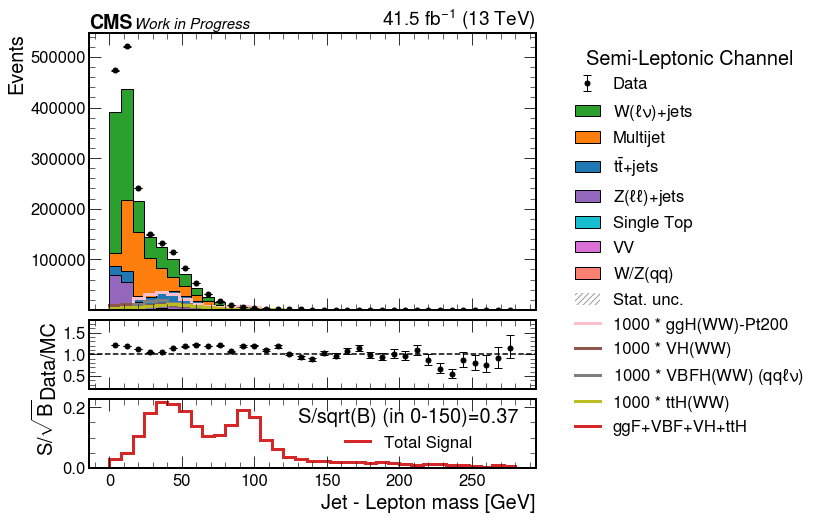

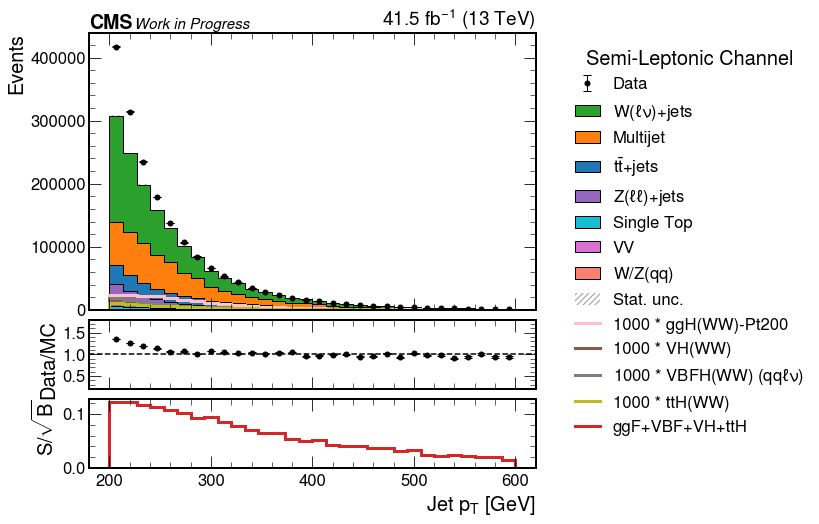

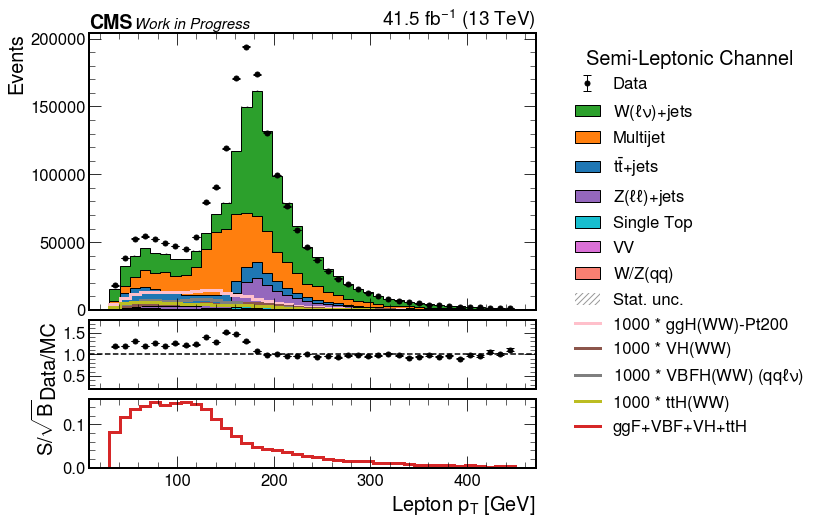

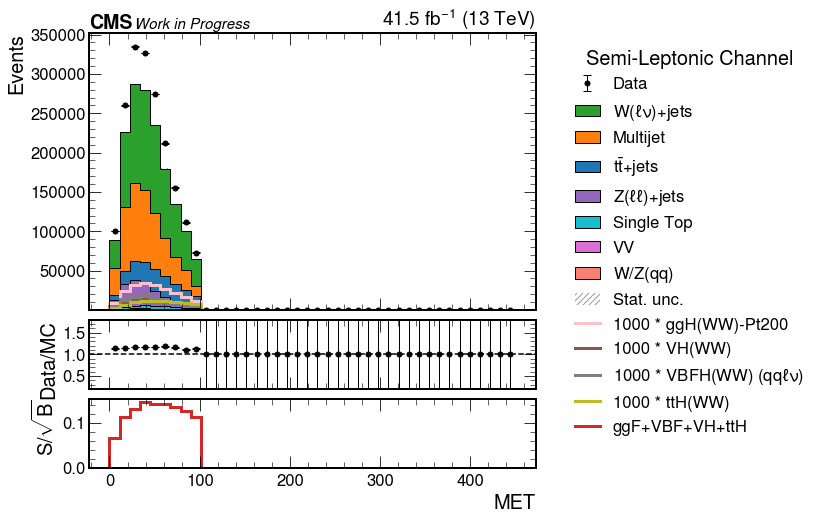

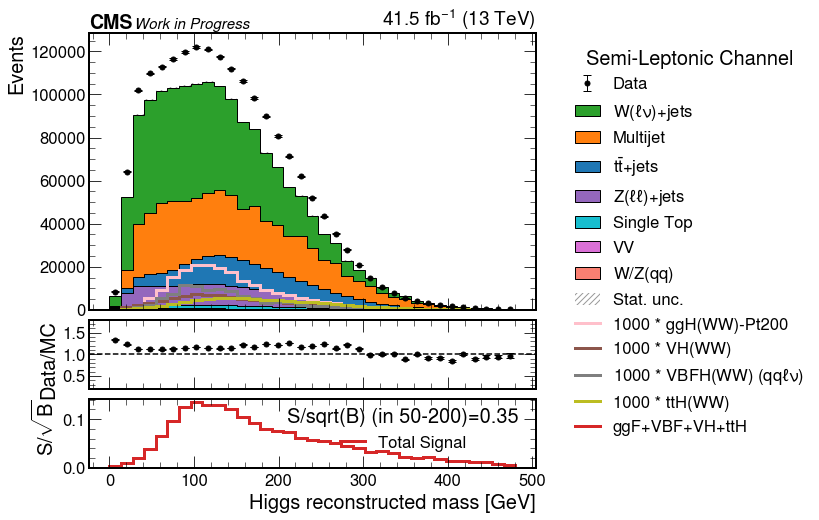

In [121]:
plt.rcParams.update({"font.size": 20})
plot_hists(year, channels, hists, vars_to_plot, logy = False, mult=1000, add_data=True)

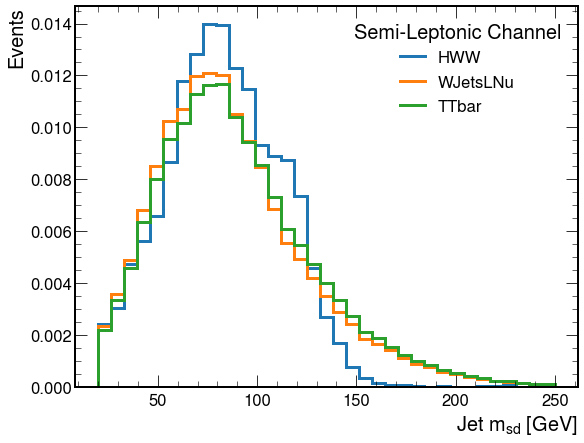

In [125]:
samples_to_plot = [
    "HWW", 
#     "VH",
#     "VBF",
#     "ttH",
#      "QCD",
#     "DYJets",
    "WJetsLNu",
    "TTbar",
]

### Example of a 1-d histogram
# make simple 1d-histogram of `lep_pt`
plt.rcParams.update({"font.size": 20})

# var = "fj_ParticleNet_mass"
# var = "met_fj_dphi"
# var = "lep_met_mt"
var = "fj_msoftdrop"

h = hist2.Hist(
    utils.axis_dict[var],
)

fig, ax = plt.subplots(figsize=(9, 7))

for sample in samples_to_plot:
    for ch in channels:

        df = events_dict[ch][sample]
        
        # tagger cut
        df = df[df["inclusive_score"]>0.99]
        
#         df = df[df["lep_fj_dr"]>0.03]        
#         df = df[df["n_bjets_M"]<2]
#         df = df[(df["rec_W_lnu_pt"]/df["rec_W_qq_pt"])<4.8]

        h.fill(
#             var=np.abs(df[var]),
            var=df[var],
            weight=df["event_weight"]
        )

    hep.histplot(
        h,
        ax=ax,
        label=sample,
        linewidth=3,
        density=True
    )

# ax.set_title("Without dR(Jet,Lepton)>0.03")
ax.legend(title=f"Semi-Leptonic Channel")
ax.set_ylabel("Events");  

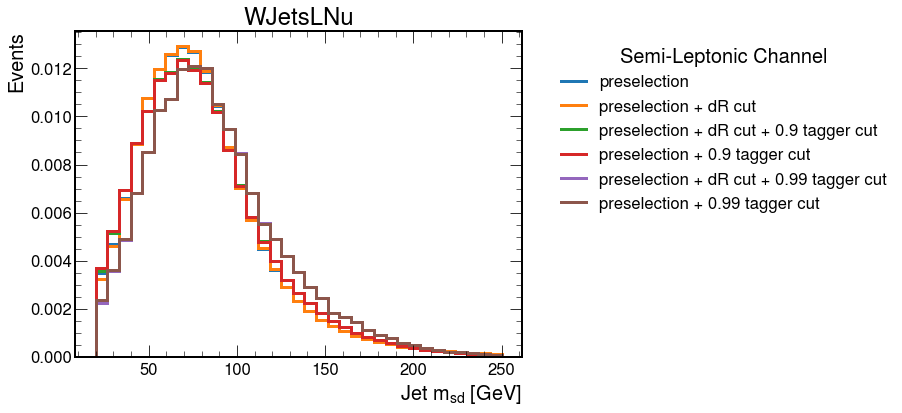

In [134]:
plt.rcParams.update({"font.size": 20})

samples_to_plot = [
#     "HWW", 
#     "VH",
#     "VBF",
#     "ttH",
#     "QCD",
#     "DYJets",
    "WJetsLNu",
#     "TTbar",
]

sample = "WJetsLNu"

var = "fj_msoftdrop"
# var = "fj_ParticleNet_mass"

h = hist2.Hist(
    hist2.axis.StrCategory([], name="cuts", growth=True),    
    utils.axis_dict[var],
)


cuts = ["preselection", 
        "preselection + dR cut", 
        "preselection + dR cut + 0.9 tagger cut",
        "preselection + 0.9 tagger cut",
        "preselection + dR cut + 0.99 tagger cut",
        "preselection + 0.99 tagger cut"
       ]

for cut in cuts:
    for ch in channels:

        df = events_dict[ch][sample]
        
        if cut == "preselection + dR cut":
            df = df[df["lep_fj_dr"]>0.03]   
        elif cut == "preselection + 0.9 tagger cut":
            df = df[df["inclusive_score"]>0.9]
        elif cut == "preselection + 0.99 tagger cut":            
            df = df[df["inclusive_score"]>0.99]            
            
        elif cut == "preselection + dR cut + 0.9 tagger cut":
            df = df[df["lep_fj_dr"]>0.03]        
            df = df[df["inclusive_score"]>0.9]
        
        elif cut == "preselection + dR cut + 0.99 tagger cut":
            df = df[df["lep_fj_dr"]>0.03]        
            df = df[df["inclusive_score"]>0.99]            

        h.fill(
            cuts=cut,
            var=df[var],
            weight=df["event_weight"]
        )
            
fig, ax = plt.subplots(figsize=(8, 6))
for cut in cuts:
        
    hep.histplot(
        h[{"cuts": cut}],
        ax=ax,
        label=cut,
        linewidth=3,
        density=True
    )

ax.legend(title=f"Semi-Leptonic Channel", bbox_to_anchor=(1.05, 1), loc="upper left")
ax.set_title(sample)
# ax.set_yscale("log")
ax.set_ylabel("Events");  

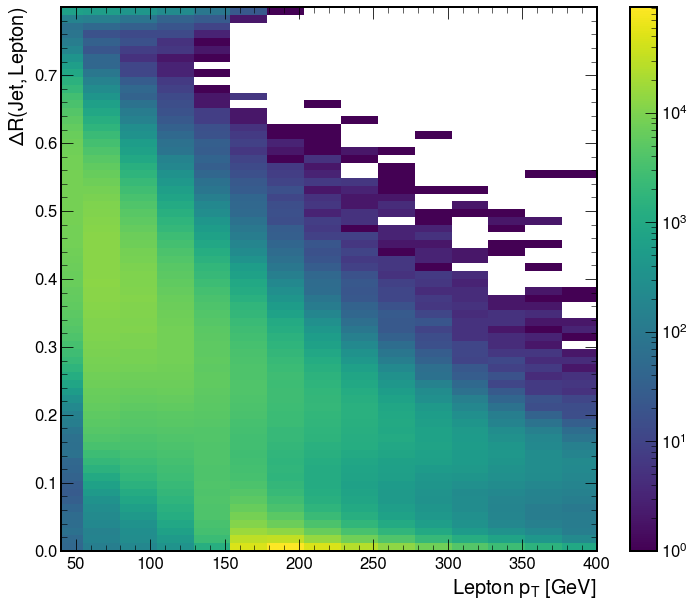

In [59]:
samples_to_plot = [
    "HWW", 
#     "VH",
#     "VBF",
#     "ttH",
     "QCD",
#     "DYJets",
    "WJetsLNu",
    "TTbar",
]
sig = ["HWW"]
bkgs = ["QCD", "WJetsLNu", "TTbar"]


from matplotlib.colors import LogNorm
fig, ax = plt.subplots(figsize=(12, 10))

for sample in ["TTbar"]:

    plt.hist2d(
        events_dict[ch][sample]["lep_pt"],
        events_dict[ch][sample]["lep_fj_dr"],
        norm=LogNorm(),
        bins=[70,70]
          )

ax.set_xlim(40,400)
# ax.set_ylim(0,0.4)
ax.set_xlabel(r"Lepton $p_T$ [GeV]");
ax.set_ylabel(r"$\Delta R(Jet, Lepton)$");
plt.colorbar()

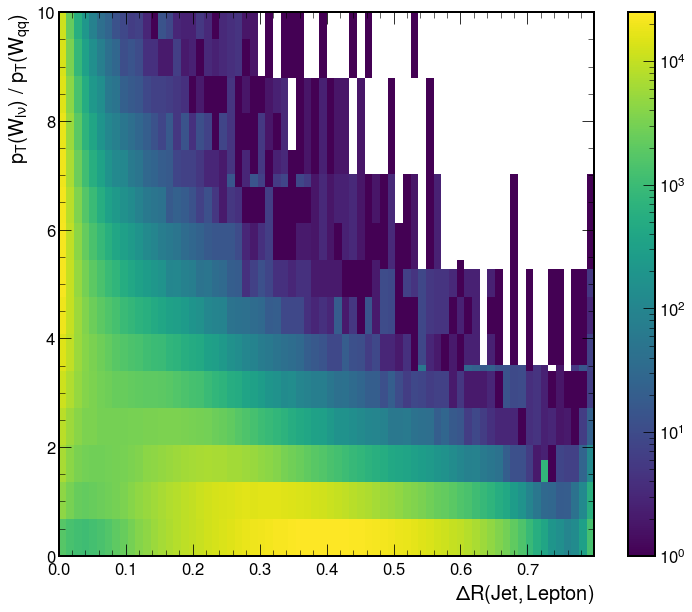

In [109]:
samples_to_plot = [
    "HWW", 
#     "VH",
#     "VBF",
#     "ttH",
     "QCD",
#     "DYJets",
    "WJetsLNu",
    "TTbar",
]
sig = ["HWW"]
bkgs = ["QCD", "WJetsLNu", "TTbar"]


from matplotlib.colors import LogNorm
fig, ax = plt.subplots(figsize=(12, 10))

for sample in bkgs:

    df = events_dict[ch][sample]
    X = df["lep_fj_dr"] 
    Y = df["rec_W_lnu_pt"]/df["rec_W_qq_pt"]

    plt.hist2d(
        X,
        Y,
        norm=LogNorm(),
        bins=[70,70]
          )

# ax.set_xlim(40,400)
ax.set_ylim(0,10)
ax.set_xlabel(r"$\Delta R(Jet, Lepton)$");
ax.set_ylabel(r"$p_{T}(W_{l\nu})$ / $p_{T}(W_{qq})$");
plt.colorbar()

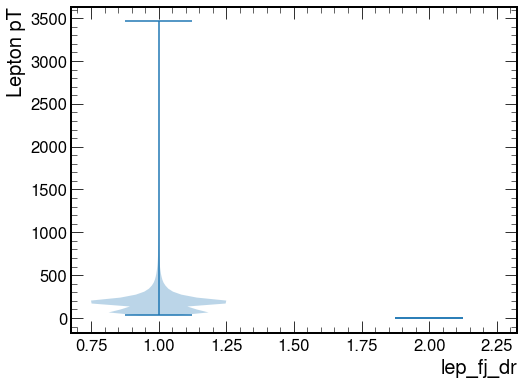

In [49]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots(figsize=(8, 6))
plt.violinplot([events_dict[ch]["WJetsLNu"]["lep_pt"],events_dict[ch]["WJetsLNu"]["lep_fj_dr"]]
              )
# ax.set_xlim(40,400)
# ax.set_ylim(40,600)
ax.set_xlabel("lep_fj_dr");
ax.set_ylabel("Lepton pT");
# plt.colorbar()

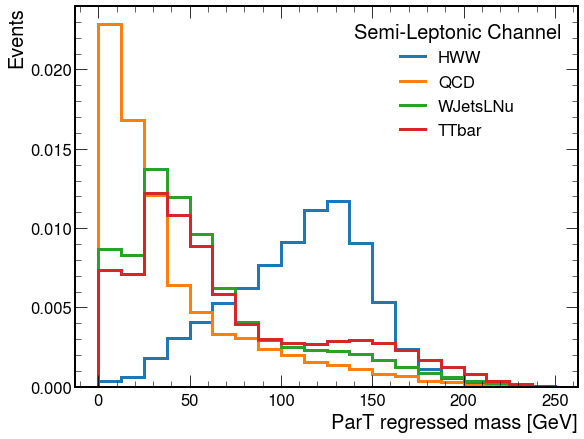

In [153]:
vars_to_plot = [
    "fj_minus_lep_m",
    "fj_pt",
#     "lep_pt",
    "fj_msoftdrop",
    "fj_msoftdrop+met",
#     "fj_bjets_ophem",
#     "fj_bjets",
#     "lep_isolation_lowpt",
#     "lep_isolation_highpt",
#     "lep_misolation_lowpt",
#     "lep_misolation_highpt",
#     "lep_fj_dr",
#     "lep_met_mt",
#     "ht",
#     "met",
#     "met_fj_dphi",
#     "nfj",
#     "nj",
#     "deta",
#     "mjj",
#     "fj_pt_over_lep_pt",
#     "rec_higgs_m",
#     "rec_higgs_pt",
#     "golden_var",
#     "rec_dphi_WW",
    "fj_ParT_mass",
#     "fj_ParticleNet_mass"
]

samples_to_plot = [
    "HWW", 
#     "VH",
#     "VBF",
#     "ttH",
     "QCD",
#     "DYJets",
    "WJetsLNu",
    "TTbar",
]

### Example of a 1-d histogram
# make simple 1d-histogram of `lep_pt`
plt.rcParams.update({"font.size": 20})

var = "fj_ParT_mass"

h = hist2.Hist(
    utils.axis_dict[var],
)

fig, ax = plt.subplots(figsize=(9, 7))

for sample in samples_to_plot:
    for ch in channels:

        df = events_dict[ch][sample]
        
        # tagger cut
#         df = df[df["inclusive_score"]>0.99]
#         df = df[df["fj_bjets"]<0.3]
#         df = df[(df["rec_W_lnu_pt"]/df["rec_W_qq_pt"])<4.8]

        h.fill(
            var=df[var],
            weight=df["event_weight"]
        )

    hep.histplot(
        h,
        ax=ax,
        label=sample,
        linewidth=3,
        density=True
    )

ax.legend(title=f"Semi-Leptonic Channel")
ax.set_ylabel("Events");  

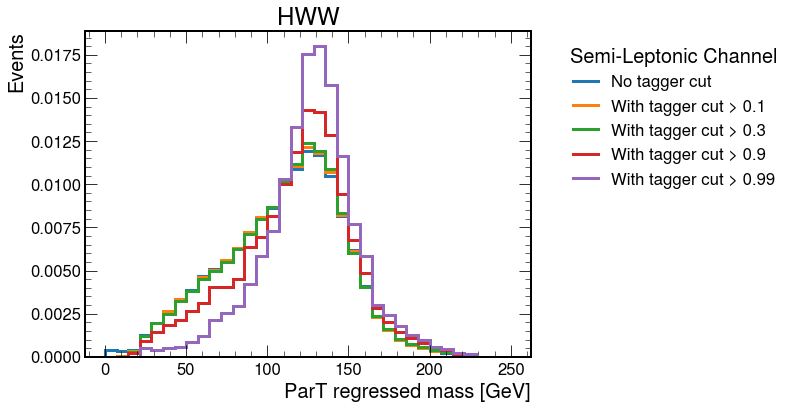

In [21]:
plt.rcParams.update({"font.size": 20})

samples_to_plot = [
#     "HWW", 
#     "VH",
#     "VBF",
#     "ttH",
#     "QCD",
#     "DYJets",
    "WJetsLNu",
#     "TTbar",
]

sample = "HWW"

var = "fj_ParT_mass"

h = hist2.Hist(
    hist2.axis.StrCategory([], name="cuts", growth=True),    
    utils.axis_dict[var],
)

cuts = [0, 0.1, 0.3, 0.9, 0.99]
for cut in cuts:
    for ch in channels:

        df = events_dict[ch][sample]
        
        # tagger cut
        df = df[df["inclusive_score"]>cut]
        
        h.fill(
            cuts=str(cut),
            var=df[var],
            weight=df["event_weight"]
        )

fig, ax = plt.subplots(figsize=(8, 6))
for cut in cuts:
    if cut==0:
        lab = "No tagger cut"
    else:
        lab = f"With tagger cut > {cut}"
        
    hep.histplot(
        h[{"cuts": str(cut)}],
        ax=ax,
        label=lab,
        linewidth=3,
        density=True
    )

ax.legend(title=f"Semi-Leptonic Channel", bbox_to_anchor=(1.05, 1), loc="upper left")
ax.set_title(sample)
# ax.set_yscale("log")
ax.set_ylabel("Events");  